In [26]:
### Keras and Tensorflow >2.0

In [27]:
### Data Collection

import matplotlib.pyplot as plt

key=""

from datetime import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

plt.rcParams["figure.figsize"] = (18,5)



In [28]:
df=pd.read_csv('https://drive.google.com/uc?export=download&id=1ZIZbKjuARboC_RdZH1ZbTS9JtmaTNFiF', sep = ',')
df = df[['Date', 'Cierre']]

df = df.reindex(index = df.index[::-1])  
Fch = np.array(df['Date'])
for idx in range(0,len(Fch)):
    tmp = Fch[idx]
    Fch[idx] = datetime.strptime(tmp,"%d/%m/%Y")
 
df['Fecha'] = pd.DataFrame(Fch)

df = df.set_index('Fecha')
df = df.drop(columns='Date')

In [29]:
df.head()

,Cierre
Fecha,
2021-12-06,1.3463
2021-12-05,1.3272
2021-12-03,1.3262
2021-12-02,1.3171
2021-12-01,1.3054


In [30]:
df.tail()

,Cierre
Fecha,
2005-01-07,1.1319
2005-01-06,1.1299
2005-01-05,1.1313
2005-01-04,1.1305
2005-01-03,1.1281


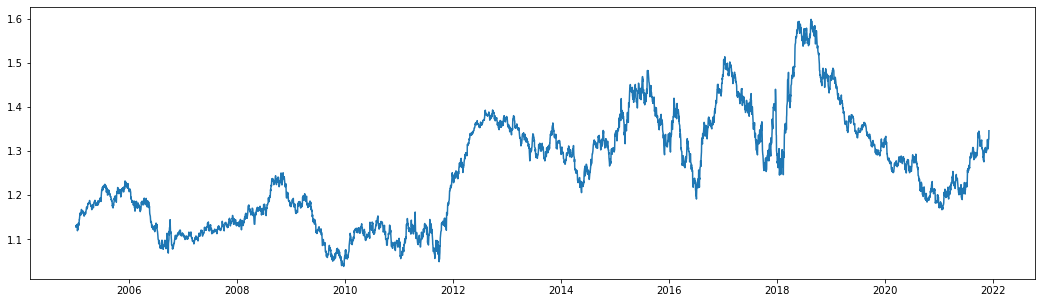

In [31]:
import matplotlib.pyplot as plt
plt.plot(df['Cierre'])

In [32]:
df_np = np.array(df['Cierre'])

In [33]:

scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df_np).reshape(-1,1))

In [34]:
print(df1)

[[0.54918765]
 [0.51508659]
 [0.5133012 ]
 ...
 [0.16532762]
 [0.1638993 ]
 [0.15961435]]


In [35]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [36]:
training_size,test_size

(2871, 1546)

In [37]:
train_data

array([[0.54918765],
       [0.51508659],
       [0.5133012 ],
       ...,
       [0.08462775],
       [0.08444921],
       [0.07927156]])

In [38]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [39]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [40]:
print(X_train.shape), print(y_train.shape)

(2820, 50)
(2820,)


(None, None)

In [41]:
print(X_test.shape), print(ytest.shape)

(1495, 50)
(1495,)


(None, None)

In [42]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [43]:
X_train.shape, X_test.shape

((2820, 50, 1), (1495, 50, 1))

In [44]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [45]:
# model = keras.models.Sequential([
#                                 keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
#                                 keras.layers.LSTM(20, return_sequences=True),
#                                 keras.layers.TimeDistributed(keras.layers.Dense(10))

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(50,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 50)            20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=5,batch_size=64,verbose=1)

Epoch 1/5
45/45 [==============================] - 58s 844ms/step - loss: 0.0581 - val_loss: 0.0021
Epoch 2/5
45/45 [==============================] - 30s 673ms/step - loss: 0.0021 - val_loss: 7.2331e-04
Epoch 3/5
45/45 [==============================] - 39s 865ms/step - loss: 0.0021 - val_loss: 5.2977e-04
Epoch 4/5
45/45 [==============================] - 37s 810ms/step - loss: 0.0019 - val_loss: 4.6764e-04
Epoch 5/5
45/45 [==============================] - 30s 658ms/step - loss: 0.0017 - val_loss: 4.3534e-04


In [48]:
import tensorflow as tf

In [49]:
import numpy as np


In [50]:
np.__version__

'1.19.2'

In [51]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train) 
test_predict=model.predict(X_test) 

In [52]:
train_predict.shape, test_predict.shape

((2820, 1), (1495, 1))

In [53]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [54]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.8193598347170516

In [55]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.9557843928885384

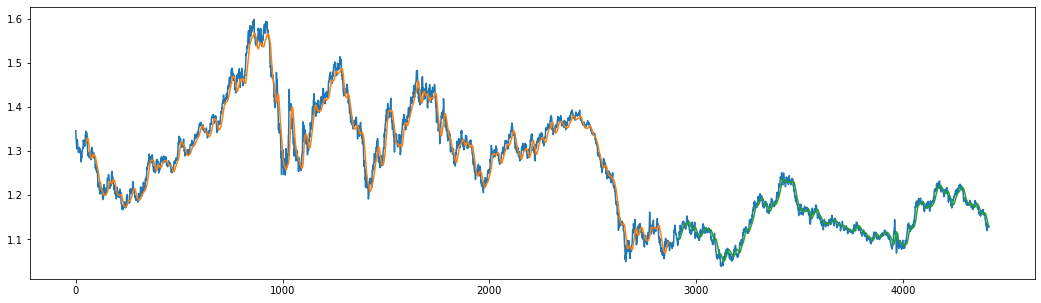

In [57]:
### Plotting 
# shift train predictions for plotting
look_back=50
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [38]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [40]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

In [42]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

In [45]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

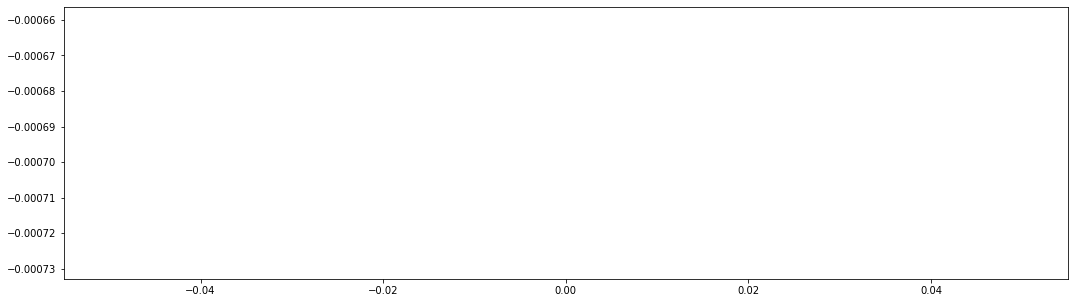

In [48]:
plt.plot(Y_pred)

In [ ]:
len(test_data)

1546

In [ ]:
x_input=test_data[341:].reshape(-1,1)
x_input.shape


(1205, 1)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input

[0.6816639885734692]

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

ValueError: ignored

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(df1)

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

In [ ]:
plt.plot(df3)